# Trabajo Práctico Aprendizaje de máquina


Integrantes

* Martin Osvaldo González
* Josmar Katherin Brazón Athanasopulos
* Martin Fernando Andres


## Librerías

In [69]:
!pip install category_encoders


In [70]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import category_encoders as ce
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

## Dataset: Full TMDB Movies Dataset 2024 (Version 685 - 05/09/2025)

### Descripción del dataset

Es el dataset completo generado desde TMDb (The Movie Database). TMDb es una base de datos de películas completa que proporciona información sobre mas de 1M de peliculas desde 1916 hasta la actualidad.

Posee las 24 variable mostradas a continuación

Nro | Variable            | Tipo      | Descripción                                                                      |
----|---------------------|-----------|----------------------------------------------------------------------------------|
01  | id                  | int       | Identificador único de cada película.                                            |
02  | title               | str       | Título de la película.                                                           |
03  | vote_average        | float     | Promedio de votos o calificación otorgada por los espectadores.                  |
04  | vote_count          | int       | Cantidad total de votos recibidos por la película.                               |
05  | status              | str       | El estado de la película (p. ej., Lanzada, Rumoreada, En postproducción, etc).   |
06  | release_date        | str       | Fecha en que la película fue estrenada.                                          |
07  | revenue             | int       | Recaudación total generada por la película.                                      |
08  | runtime             | int       | Duración de la película en minutos.                                              |
09  | adult               | bool      | Indica si la película es apta solo para audiencias adultas.                      |
10  | backdrop_path       | str       | URL de la imagen de fondo de la película.                                        |
11  | budget              | int       | Presupuesto asignado para la película.                                           |
12  | homepage            | str       | URL de la página oficial de la película                                          |
13  | imdb_id             | str       | ID de IMDb de la película.                                                       |
14  | original_language   | str       | Idioma original en el que se produjo la película.                                |
15  | original_title      | str       | Título original de la película.                                                  |
16  | overview            | str       | Descripción breve o sinopsis de la película.                                     |
17  | popularity          | float     | Puntuación de popularidad de la película.                                        |
18  | poster_path         | str       | URL de la imagen del póster de la película.                                      |
19  | tagline             | str       | Eslogan o frase memorable asociada con la película.                              |
20  | genres              | str       | Lista de géneros a los que pertenece la película.                                |
21  | production_companies| str       | Lista de compañías productoras involucradas en la película.                      |
22  | production_countries| str       | Lista de países involucrados en la producción de la película.                    |
23  | spoken_languages    | str       | Lista de idiomas hablados en la película.                                        |
24  | keywords            | str       | Lista de palabras clave asociadas con la película.                               |

### Objetivo: Evaluar distintos modelos de clasificación para predecir la categoría de popularidad de una película

**Popularity** representa una medida relativa de interés del público hacia una película. Es un puntaje calculado por TMDb que refleja cuán popular es una película en la plataforma, basado en su actividad de usuarios.

TMDb no publica la fórmula exacta (es propietaria), pero la comunidad ha documentado que combina los siguientes factores:

|Factor | Descripción |
|-------|-------------|
|Número de votos (vote_count)|	Cuántos usuarios calificaron la película |
|Promedio de votos (vote_average)|	Qué tan alta es la calificación |
|Recencia|	Cuánto tiempo pasó desde el lanzamiento (películas nuevas tienden a tener más tráfico)|
|Tráfico / vistas / búsquedas|	Cuántas veces fue vista o accedida en TMDb recientemente|

Para este trabajo, se establecieron como objetivo tres rangos de popularidad:

| Clase | Rango de Popularidad | Interpretación |
|--------|------------------------|----------------|
| **0 — Baja** | 0 - 1 | Películas con poca o nula atención. |
| **1 — Media** | 1 - 10 | Películas conocidas o con cierto éxito. |
| **2 — Alta** | > 10 | Películas muy populares o éxitos de taquilla. |

### Carga del Dataset

In [71]:
!pip install kagglehub --quiet

# Fuerza a KaggleHub a volver a descargar la versión correcta
dir = kagglehub.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")
name = os.listdir(dir)[0]
path = os.path.join(dir, name)

print("Dataset descargado en:", path)


Dataset descargado en: C:\Users\tincho\.cache\kagglehub\datasets\asaniczka\tmdb-movies-dataset-2023-930k-movies\versions\728\TMDB_movie_dataset_v11.csv


In [72]:
# Lectura segura del CSV (sin conflictos de opciones)
df = pd.read_csv(path, on_bad_lines='skip')

# Confirmamos
print("✅ Dataset cargado correctamente")
print(f"📊 Filas: {df.shape[0]} | Columnas: {df.shape[1]}")

✅ Dataset cargado correctamente
📊 Filas: 1305649 | Columnas: 24


In [73]:
df.head(5)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305649 entries, 0 to 1305648
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1305649 non-null  int64  
 1   title                 1305633 non-null  object 
 2   vote_average          1305649 non-null  float64
 3   vote_count            1305649 non-null  int64  
 4   status                1305649 non-null  object 
 5   release_date          1044619 non-null  object 
 6   revenue               1305649 non-null  int64  
 7   runtime               1305649 non-null  int64  
 8   adult                 1305649 non-null  bool   
 9   backdrop_path         333367 non-null   object 
 10  budget                1305649 non-null  int64  
 11  homepage              135689 non-null   object 
 12  imdb_id               642534 non-null   object 
 13  original_language     1305649 non-null  object 
 14  original_title        1305633 non-

### Preprocesamiento

Se eliminan observaciones duplicadas.

In [75]:
# Cantidad de datos duplicados
print("Cantidad de datos duplicados:", df.duplicated().sum())

# Borro todas las duplicadas que tienen el mismo título y release_date
df = df.drop_duplicates(subset=['title', 'release_date'], keep='first')

# Verifico que no hayan quedado duplicados
print("Duplicados restantes:", df.duplicated(subset=['title', 'release_date']).sum())
print(f"Observaciones: {df.shape[0]} | Características: {df.shape[1]}")

Cantidad de datos duplicados: 377
Duplicados restantes: 0
Observaciones: 1282889 | Características: 24


Se convierte 'release_date' a formato DateTime

In [76]:
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_date"] = df["release_date"].replace({pd.NaT: np.nan})
df["release_date"].dtypes

dtype('<M8[ns]')

Se reemplazan ceros por nan en variables numericas

In [77]:
# Reemplazo ceros por NaN en columnas específicas
cols = ["revenue", "budget", "runtime"]
df[cols] = df[cols].replace(0, np.nan)

### Análisis del target

Descripción de Popularity

In [78]:
df['popularity'].describe()

count    1.282889e+06
mean     1.110553e+00
std      7.150841e+00
min      0.000000e+00
25%      6.000000e-01
50%      6.000000e-01
75%      8.400000e-01
max      2.994357e+03
Name: popularity, dtype: float64

Histograma de popularity

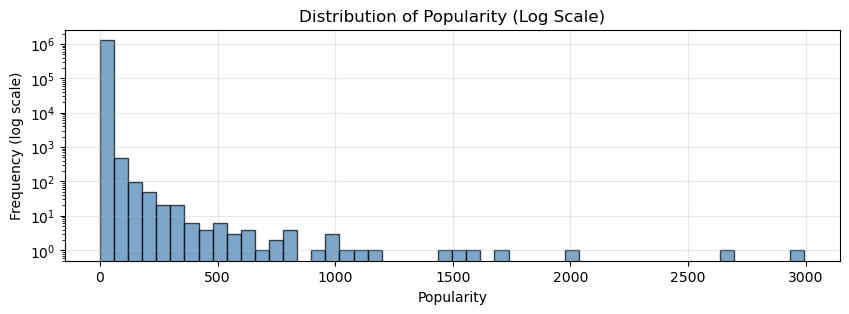

,title,popularity,release_date,vote_average,vote_count
0,Inception,83.952,2010-07-15,8.364,34495
1,Interstellar,140.241,2014-11-05,8.417,32571
2,The Dark Knight,130.643,2008-07-16,8.512,30619
3,Avatar,79.932,2009-12-15,7.573,29815
4,The Avengers,98.082,2012-04-25,7.710,29166
5,Deadpool,72.735,2016-02-09,7.606,28894
6,Avengers: Infinity War,154.340,2018-04-25,8.255,27713
7,Fight Club,69.498,1999-10-15,8.438,27238
8,Guardians of the Galaxy,33.255,2014-07-30,7.906,26638
9,Pulp Fiction,74.862,1994-09-10,8.488,25893


In [79]:
plt.figure(figsize=(10,3))

# Graficar histograma
plt.hist(df["popularity"], bins=50, color="steelblue", edgecolor="black", alpha=0.7)

# Escala logarítmica en el eje Y
plt.yscale("log")

plt.title("Distribution of Popularity (Log Scale)")
plt.xlabel("Popularity")
plt.ylabel("Frequency (log scale)")
plt.grid(True, alpha=0.3)
plt.show()

# Filtrar películas con popularity > 10
top_popular = df[df["popularity"] > 10]
#top_popular = top_popular.sort_values(by="release_date", ascending=True)
top_popular[["title", "popularity", "release_date", "vote_average", "vote_count"]].head(10)

Creación de las clases

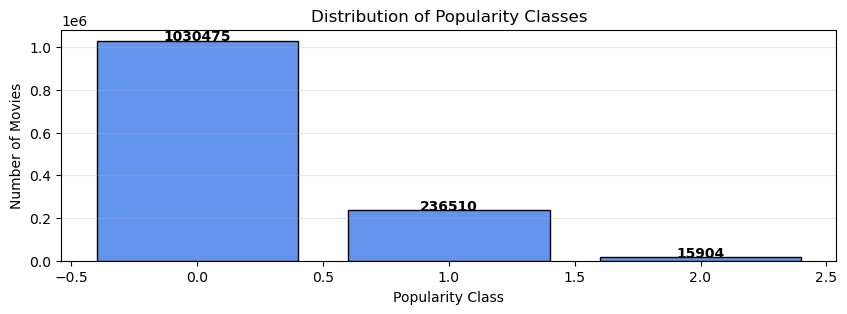

In [80]:
df["popularity_class"] = pd.cut(
    df["popularity"],
    bins=[-1, 1, 10, df["popularity"].max()],
    labels=[0, 1, 2]  # 0 = low, 1 = medium, 2 = high
).astype("int")

plt.figure(figsize=(10,3))

# Contar cuántas películas hay por clase
class_counts = df["popularity_class"].value_counts()

# Graficar barras
plt.bar(class_counts.index, class_counts.values, color="cornflowerblue", edgecolor="black")

# Títulos y etiquetas
plt.title("Distribution of Popularity Classes")
plt.xlabel("Popularity Class")
plt.ylabel("Number of Movies")
plt.grid(True, axis="y", alpha=0.3)

# Mostrar valores sobre las barras
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 50, str(v), ha="center", fontweight="bold")

plt.show()

### Split del dataset

Se eliminan caractéristicas innecesarias (para el objetivo de este trabajo)

In [81]:
df = df.drop(columns=['id', 'title', 'backdrop_path', 'homepage', 'imdb_id', 'original_title', 'overview', 'poster_path', 'tagline'],
             errors='ignore')
print(f"Observaciones: {df.shape[0]} | Características: {df.shape[1]}")

Observaciones: 1282889 | Características: 16


Selección de target y split del dataset

In [82]:
# Definir la variable objetivo a predecir (clasificacion)
y = df['popularity_class']
X = df.drop(columns=['popularity_class', 'popularity'])

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # mantiene la proporción de clases
    random_state=42
)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1026311, 14)
y_train: (1026311,)
X_test: (256578, 14)
y_test: (256578,)


### Análisis de nulos

Cantidad de nulos

In [83]:
# Cantidad de nulos por columna
nulos = X_train.isnull().sum()

# Porcentaje de nulos (sobre el total de filas)
porcentaje = (nulos / len(X_train)) * 100

# Combinar en un solo DataFrame
nulos_df = pd.DataFrame({
    'nulos': nulos,
    'porcentaje': porcentaje
})

# Ordenar de mayor a menor
nulos_df = nulos_df.sort_values(by='nulos', ascending=False)

# Mostrar
print(nulos_df)

                        nulos  porcentaje
revenue               1008267   98.241858
budget                 970509   94.562857
keywords               761180   74.166603
production_companies   574388   55.966271
production_countries   475939   46.373760
spoken_languages       457438   44.571090
genres                 432545   42.145607
runtime                301849   29.411065
release_date           192680   18.774036
vote_average                0    0.000000
status                      0    0.000000
vote_count                  0    0.000000
original_language           0    0.000000
adult                       0    0.000000


Revenue, Budget y Keywords: Se eliminan las las características por alto porcentage de nulos (> 70%)

In [84]:
columns = ['revenue', 'budget', 'keywords']

X_train = X_train.drop(columns=columns, errors='ignore')
X_test = X_test.drop(columns=columns, errors='ignore')

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (1026311, 11)
X_test: (256578, 11)


Release Date: Se imputa con mediana por Status

In [85]:
# Contar nulos en release_date por cada status
nulos_por_status = X_train.groupby("status")["release_date"].apply(lambda x: x.isna().sum())

# Contar totales por cada status
total_por_status = X_train["status"].value_counts()

# Unir ambas series en un mismo DataFrame
nulos_status_df = pd.concat([total_por_status, nulos_por_status], axis=1)
nulos_status_df.columns = ["total", "release_date_nulls"]

# Calcular el porcentaje de nulos
nulos_status_df["null_percentage"] = (nulos_status_df["release_date_nulls"] / nulos_status_df["total"] * 100).round(2)

# Mostrar resultado ordenado por porcentaje de nulos
nulos_status_df.sort_values(by="null_percentage", ascending=False)

,total,release_date_nulls,null_percentage
status,,,
Canceled,236,221,93.64
Rumored,386,361,93.52
Planned,6765,5731,84.72
Post Production,9092,5875,64.62
In Production,13591,4784,35.20
Released,996241,175708,17.64


In [86]:
# Calcular la mediana por grupo

release_date_medians = (
    X_test[X_test["release_date"].notna()]
    .groupby("status")["release_date"]
    .median()
    .sort_values()
)

# Mostrar resultados
print(release_date_medians)

status
Released          2011-03-24 12:00:00
Post Production   2024-10-05 00:00:00
Planned           2025-01-11 00:00:00
In Production     2025-01-24 00:00:00
Rumored           2027-01-01 00:00:00
Canceled          2029-10-26 00:00:00
Name: release_date, dtype: datetime64[ns]


In [87]:
# Imputo medianas por grupo

if X_train["release_date"].isna().any():
    X_train["release_date"] = X_train["release_date"].fillna(
        X_train["status"].map(release_date_medians)
    )

if X_test["release_date"].isna().any():
    X_test["release_date"] = X_test["release_date"].fillna(
        X_test["status"].map(release_date_medians)
    )

Runtime: Se imputa con mediana

In [88]:
runtime_median = X_train['runtime'].median()
print(runtime_median)

X_train["runtime"] = X_train["runtime"].fillna(runtime_median)
X_test["runtime"] = X_test["runtime"].fillna(runtime_median)

66.0


Variables categóricas: Se van a codificar con OneHotEncoder, MultiLabelBinarizer y TargetEncoder.
                       No se requiere tratamiento previo.

### Creación de características

Se crea days_since _realese

In [89]:
# Fecha publicacion dataset

ds_publication_date = pd.to_datetime('2025-09-05')

# Calcular días transcurridos desde el release
X_train["days_since_release"] = (ds_publication_date - X_train["release_date"]).dt.days
X_test["days_since_release"] = (ds_publication_date - X_test["release_date"]).dt.days

X_train = X_train.drop(columns=["release_date"], errors='ignore')
X_test = X_test.drop(columns=["release_date"], errors='ignore')

### Codificacion de categóricas

Informacion del train

In [90]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1026311 entries, 1056041 to 1111065
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vote_average          1026311 non-null  float64
 1   vote_count            1026311 non-null  int64  
 2   status                1026311 non-null  object 
 3   runtime               1026311 non-null  float64
 4   adult                 1026311 non-null  bool   
 5   original_language     1026311 non-null  object 
 6   genres                593766 non-null   object 
 7   production_companies  451923 non-null   object 
 8   production_countries  550372 non-null   object 
 9   spoken_languages      568873 non-null   object 
 10  days_since_release    1026311 non-null  int64  
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 87.1+ MB


Adult: Directo a Float

In [91]:
X_train["adult"] = X_train["adult"].astype(float)
X_test["adult"] = X_test["adult"].astype(float)

Status: OneHotEncoder

In [92]:
status_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
status_ohe.fit(X_train[["status"]])

status_train_encoded = status_ohe.transform(X_train[["status"]])
status_test_encoded = status_ohe.transform(X_test[["status"]])

cols_encoded = status_ohe.get_feature_names_out(["status"])

X_train_status_ohe = pd.DataFrame(status_train_encoded, columns=cols_encoded, index=X_train.index)
X_test_status_ohe = pd.DataFrame(status_test_encoded, columns=cols_encoded, index=X_test.index)

X_train = pd.concat([X_train.drop(columns=["status"]), X_train_status_ohe], axis=1)
X_test = pd.concat([X_test.drop(columns=["status"]), X_test_status_ohe], axis=1)

Genres: MultiLabelBinarizer

In [93]:
# Coonvertir strings a listas de etiquetas

for df_part in [X_train, X_test]:
    df_part["genres_list"] = df_part["genres"].apply(
        lambda x: [s.strip() for s in x.split(",")] if isinstance(x, str) else []
    )

# Ajustar solo con train
mlb = MultiLabelBinarizer()
mlb.fit(X_train["genres_list"])

# Transformar ambos
train_genres = pd.DataFrame(
    mlb.transform(X_train["genres_list"]),
    columns=[f"genres_{cls}" for cls in mlb.classes_],
    index=X_train.index
)
test_genres = pd.DataFrame(
    mlb.transform(X_test["genres_list"]),
    columns=[f"genres_{cls}" for cls in mlb.classes_],
    index=X_test.index
)

# Concatenar con los datasets originales
X_train = pd.concat([X_train.drop(columns=['genres', 'genres_list']), train_genres], axis=1)
X_test = pd.concat([X_test.drop(columns=['genres', 'genres_list']), test_genres], axis=1)

print(f"✅ MultiLabelBinarizer aplicado. {len(mlb.classes_)} géneros detectados.")

✅ MultiLabelBinarizer aplicado. 19 géneros detectados.


Original Language, Production Countries, Production Companies, Spoken Languages : TargetEncoder

In [94]:
cols_multilabel = ['original_language', 'production_countries', 'production_companies', 'spoken_languages' ]

def target_encode_multilabel(X_train, X_test, y_train, col, smoothing=0.3):
    """
    Aplica Target Encoding a una columna multietiqueta (lista separada por comas),
    utilizando un vector de target (y_train) externo.

    Parámetros:
        X_train, X_test : pd.DataFrame
            Conjuntos de entrenamiento y prueba.
        y_train : pd.Series o np.ndarray
            Variable objetivo correspondiente a X_train.
        col : str
            Nombre de la columna multietiqueta (por ejemplo 'production_companies').
        smoothing : float, opcional
            Factor de suavizado para el TargetEncoder.

    Retorna:
        X_train_mod, X_test_mod, encoder
    """

    # Convertir string → lista
    for df in [X_train, X_test]:
        df[f"{col}_list"] = df[col].apply(
            lambda x: [s.strip() for s in x.split(",")] if isinstance(x, str) else []
        )

    # Explotar listas (una fila por etiqueta)
    train_exploded = X_train.explode(f"{col}_list").rename(columns={f"{col}_list": "label"})
    test_exploded = X_test.explode(f"{col}_list").rename(columns={f"{col}_list": "label"})

    # Asignar y_train a las filas explotadas (por índice)
    train_exploded[target_col := "target_tmp"] = y_train.loc[train_exploded.index].values

    # Crear y ajustar el encoder con train
    encoder = ce.TargetEncoder(cols=["label"], smoothing=smoothing)
    encoder.fit(train_exploded["label"], train_exploded[target_col])

    # Transformar train y test
    train_exploded["label_te"] = encoder.transform(train_exploded["label"])
    test_exploded["label_te"] = encoder.transform(test_exploded["label"])

    # Reagrupar por índice original (promedio por fila)
    X_train[f"{col}_te"] = train_exploded.groupby(train_exploded.index)["label_te"].mean()
    X_test[f"{col}_te"] = test_exploded.groupby(test_exploded.index)["label_te"].mean()

    # Limpiar columnas originales
    X_train = X_train.drop(columns=[col, f"{col}_list"], errors="ignore")
    X_test = X_test.drop(columns=[col, f"{col}_list"], errors="ignore")

    print(f"✅ TargetEncoder aplicado a '{col}'. Nueva columna: '{col}_te'")

    return X_train, X_test, encoder

for col in cols_multilabel:
    X_train, X_test, _ = target_encode_multilabel(X_train, X_test, y_train, col, smoothing=0.3)

✅ TargetEncoder aplicado a 'original_language'. Nueva columna: 'original_language_te'
✅ TargetEncoder aplicado a 'production_countries'. Nueva columna: 'production_countries_te'
✅ TargetEncoder aplicado a 'production_companies'. Nueva columna: 'production_companies_te'
✅ TargetEncoder aplicado a 'spoken_languages'. Nueva columna: 'spoken_languages_te'


### Análisis de outliers

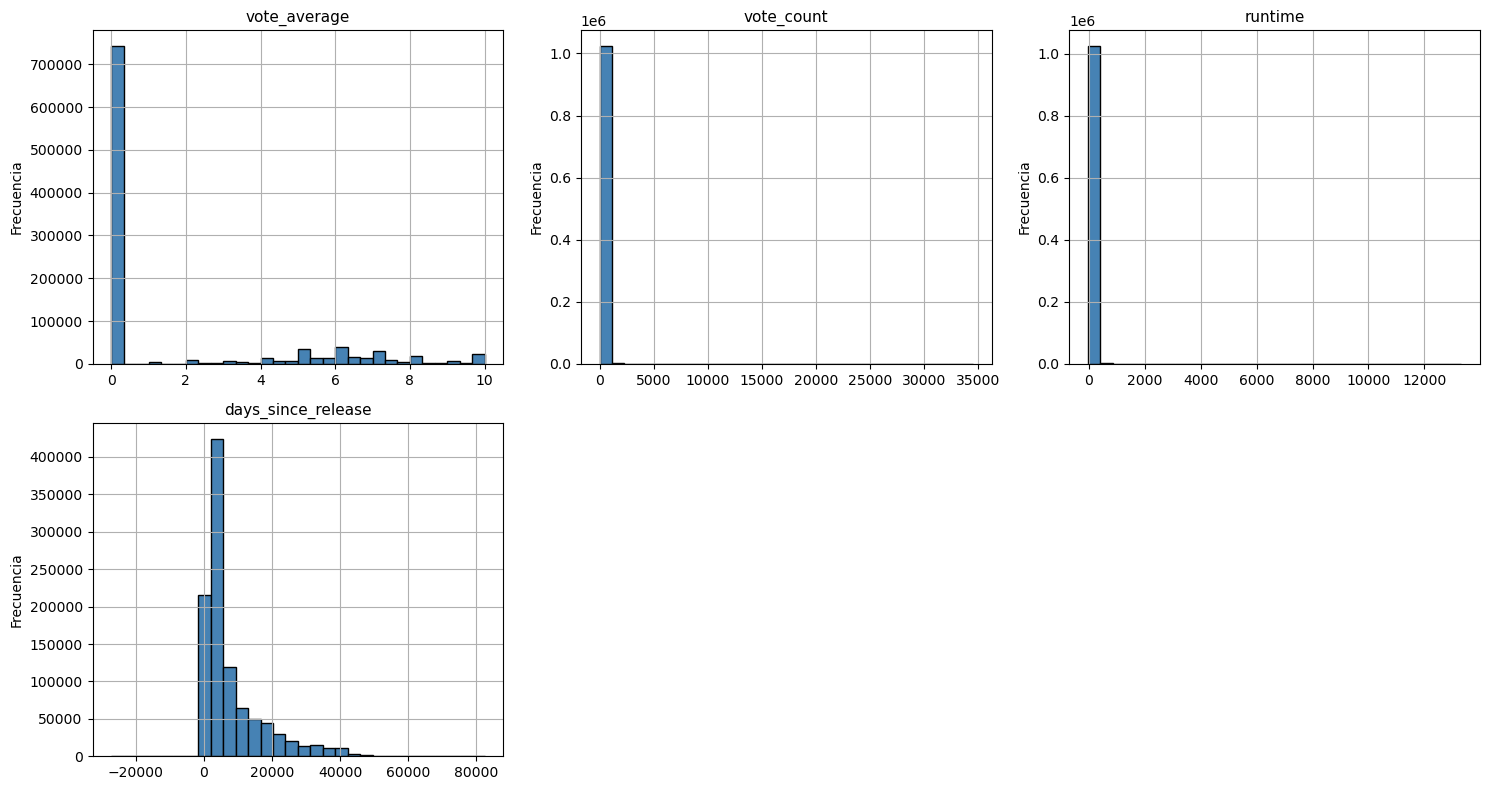

In [95]:
# Lista de columnas numéricas
num_cols = [
    'vote_average', 'vote_count', 'runtime', 'days_since_release'
]

# Configurar los subplots
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # calcula filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # para iterar fácilmente

# Crear histogramas
for i, col in enumerate(num_cols):
    ax = axes[i]
    X_train[col].hist(ax=ax, bins=30, color='steelblue', edgecolor='black')
    ax.set_title(col, fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")

# Si sobran ejes vacíos, los ocultamos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

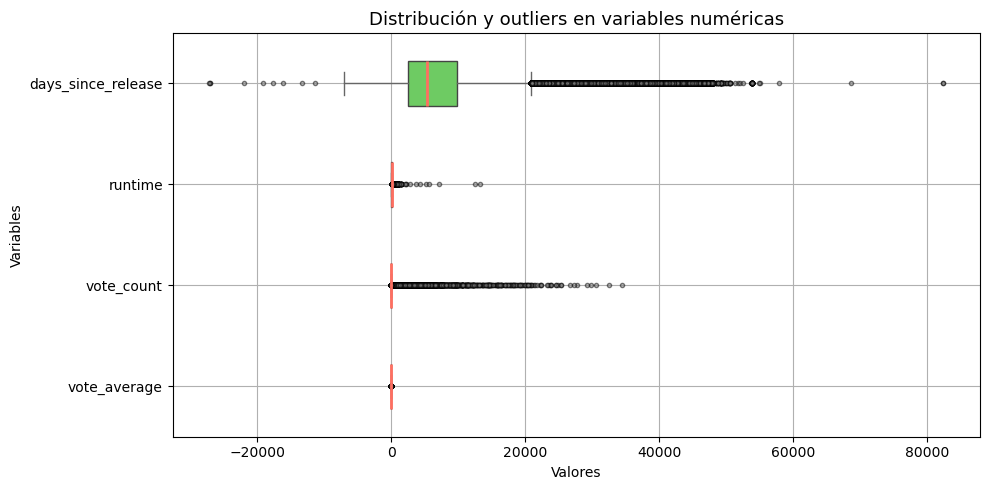

In [96]:
import matplotlib.pyplot as plt

# Variables numéricas reales (sin las codificadas con _te)
num_cols = [
    'vote_average',
    'vote_count',
    'runtime',
    'days_since_release', 'budget'
]

# Verificamos que existan en el dataset
num_cols = [c for c in num_cols if c in X_train.columns]

# Gráfico combinado
plt.figure(figsize=(10, 5))
X_train[num_cols].boxplot(
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#6ECB63", color="#444"),
    medianprops=dict(color="#FF6F61", linewidth=2),
    whiskerprops=dict(color="#666"),
    capprops=dict(color="#666"),
    flierprops=dict(markerfacecolor="gray", markersize=3, alpha=0.5)
)
plt.title("Distribución y outliers en variables numéricas", fontsize=13)
plt.xlabel("Valores")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


Runtime: Imputacion con mediana

In [97]:
# No deben existir películas con 0 o 1 minuto ni mayores a 5 horas (300 min)
min_runtime = 30     # películas menores a esto no se consideran "largometrajes"
max_runtime = 300    # 5 horas es un límite razonable

# Detectar cuántas películas están fuera del rango
anomalos = ((X_train['runtime'] < min_runtime) | (X_train['runtime'] > max_runtime)).sum()
print(f"\nPelículas con runtime fuera de rango: {anomalos}")

# Calcular mediana válida del rango lógico
mediana_runtime = X_train.loc[
    (X_train['runtime'] >= min_runtime) & (X_train['runtime'] <= max_runtime),
    'runtime'
].median()

# Reemplazar valores anómalos por la mediana calculada
for X in (X_train, X_test):
    X.loc[(X['runtime'] < min_runtime) | (X['runtime'] > max_runtime), 'runtime'] = mediana_runtime

print(f"Mediana usada para reemplazo: {mediana_runtime}")


Películas con runtime fuera de rango: 262931
Mediana usada para reemplazo: 66.0


Transformación logarítmica para reducir impacto de colas

In [98]:
cols_to_log = ['days_since_release', 'vote_count']

def apply_log_transform(train_df, test_df, cols):
    for df in [train_df, test_df]:
        for col in cols:
            if col in df.columns:
                # Asegurar que no existan valores negativos
                df[col] = np.where(df[col] < 0, 0, df[col])
                df[col] = np.log1p(df[col])
            else:
                print(f"Columna '{col}' no encontrada en el DataFrame.")
    return train_df, test_df

X_train, X_test = apply_log_transform(X_train, X_test, num_cols)

In [99]:
# Verificar rango válido para vote_average (0 a 10)
out_of_range = X_train[(X_train['vote_average'] < 0) | (X_train['vote_average'] > 10)]
print(f"Películas con vote_average fuera del rango [0, 10]: {len(out_of_range)}\n")
display(out_of_range[['vote_average']].head(10))

# Como no existen valores fuera del rango permitido, no se realizará tratamiento adicional.

Películas con vote_average fuera del rango [0, 10]: 0



,vote_average


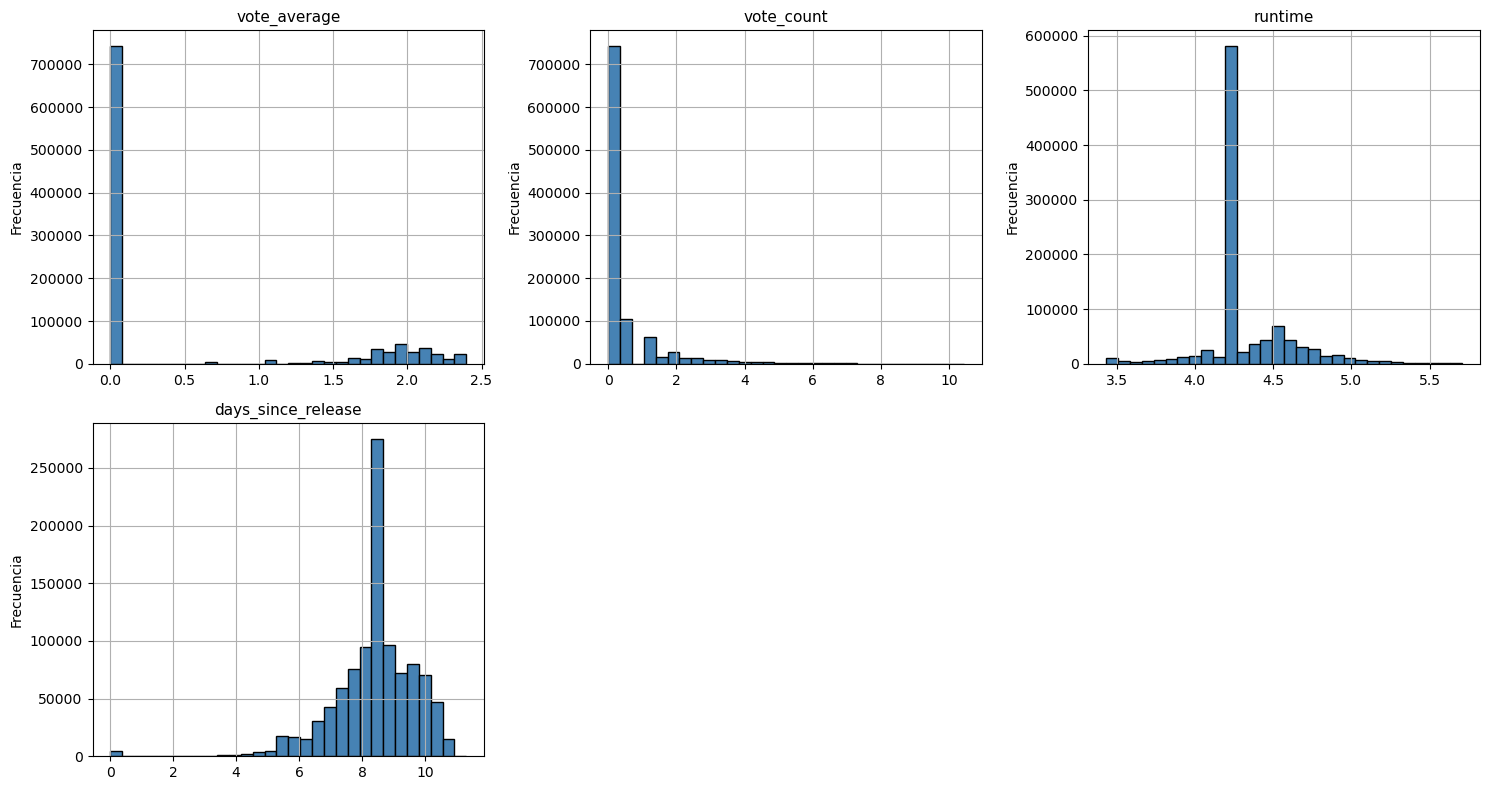

In [100]:
# Lista de columnas numéricas
num_cols = [
    'vote_average', 'vote_count', 'runtime', 'days_since_release'
]

# Configurar los subplots
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # calcula filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # para iterar fácilmente

# Crear histogramas
for i, col in enumerate(num_cols):
    ax = axes[i]
    X_train[col].hist(ax=ax, bins=30, color='steelblue', edgecolor='black')
    ax.set_title(col, fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")

# Si sobran ejes vacíos, los ocultamos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [101]:
total = X_train.shape[0]

cols = ['vote_average', 'vote_count']
resultados = {}

for c in cols:
    ceros = (X_train[c] == 0).sum()
    porcentaje = (ceros / total) * 100
    resultados[c] = {"cantidad": ceros, "porcentaje": porcentaje}

# Mostrar resultados ordenados
for col, info in resultados.items():
    print(f"{col}: {info['cantidad']} películas ({info['porcentaje']:.2f}%) con valor 0")


vote_average: 742498 películas (72.35%) con valor 0
vote_count: 742279 películas (72.32%) con valor 0


### Normalización

In [102]:
# Lista de columnas numéricas a escalar
num_cols = ['vote_average', 'vote_count', 'runtime', 'days_since_release', 'original_language_te', 'production_countries_te', 'production_companies_te', 'spoken_languages_te']

# Crear el scaler
scaler = MinMaxScaler()

# Ajustar sobre el train y transformar ambos conjuntos
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train.describe()

,vote_average,vote_count,runtime,adult,days_since_release,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,...,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,original_language_te,production_countries_te,production_companies_te,spoken_languages_te
count,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,...,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06,1.026311e+06
mean,2.212251e-01,4.590284e-02,3.900228e-01,1.001032e-01,7.425103e-01,2.299498e-04,1.324257e-02,6.591569e-03,8.858913e-03,9.707009e-01,...,4.432380e-02,1.819916e-02,1.916768e-02,3.933993e-02,8.665015e-03,7.106033e-03,3.546580e-01,3.145913e-01,1.063814e-01,2.018934e-01
std,3.650316e-01,1.019134e-01,1.283305e-01,3.001377e-01,1.179039e-01,1.516236e-02,1.143119e-01,8.092050e-02,9.370401e-02,1.686437e-01,...,2.058136e-01,1.336711e-01,1.371142e-01,1.944025e-01,9.268193e-02,8.399729e-02,1.012590e-01,2.364550e-01,1.015972e-01,1.609910e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.390513e-01,0.000000e+00,6.917181e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.220216e-01,8.745780e-02,5.492264e-02,4.136626e-02
50%,0.000000e+00,0.000000e+00,3.390513e-01,0.000000e+00,7.572203e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.507781e-01,2.570591e-01,5.492264e-02,1.637591e-01
75%,6.541636e-01,6.633877e-02,4.589939e-01,0.000000e+00,8.122054e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.507781e-01,5.540774e-01,1.519527e-01,3.600765e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


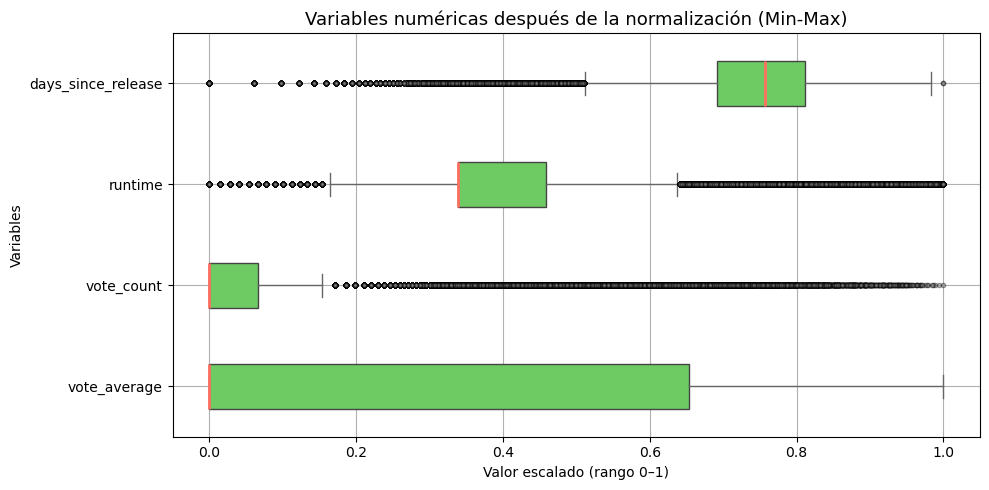

In [103]:
import matplotlib.pyplot as plt

# Solo las variables numéricas originales (sin las codificadas _te)
num_cols = ['vote_average', 'vote_count', 'runtime', 'days_since_release']

# Verificamos que existan
num_cols = [c for c in num_cols if c in X_train.columns]

# Boxplot
plt.figure(figsize=(10, 5))
X_train[num_cols].boxplot(
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#6ECB63", color="#444"),
    medianprops=dict(color="#FF6F61", linewidth=2),
    whiskerprops=dict(color="#666"),
    capprops=dict(color="#666"),
    flierprops=dict(markerfacecolor="gray", markersize=3, alpha=0.4)
)
plt.title("Variables numéricas después de la normalización (Min-Max)", fontsize=13)
plt.xlabel("Valor escalado (rango 0–1)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


### Balance de clases

In [104]:
# Elimina popularity

bal = RandomUnderSampler(random_state=42)

X_train_bal, y_train_bal = bal.fit_resample(X_train, y_train)

X_train_bal.describe()



,vote_average,vote_count,runtime,adult,days_since_release,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,...,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,original_language_te,production_countries_te,production_companies_te,spoken_languages_te
count,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,...,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000
mean,0.492314,0.228076,0.447083,0.054232,0.749071,0.000210,0.011397,0.004323,0.006576,0.977311,...,0.102780,0.052006,0.029396,0.120333,0.019545,0.013859,0.371071,0.437739,0.212092,0.287218
std,0.406618,0.259241,0.131307,0.226479,0.109841,0.014476,0.106147,0.065607,0.080827,0.148911,...,0.303675,0.222041,0.168915,0.325355,0.138431,0.116909,0.113694,0.230270,0.184555,0.151553
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046365,0.073089,0.000000,0.009135
25%,0.000000,0.000000,0.339051,0.000000,0.689944,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350778,0.087458,0.054923,0.135227
50%,0.754115,0.105144,0.453966,0.000000,0.757220,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350778,0.536453,0.151953,0.338051
75%,0.845749,0.455772,0.532485,0.000000,0.826716,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350778,0.617756,0.323896,0.399677
max,1.000000,1.000000,1.000000,1.000000,0.962330,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


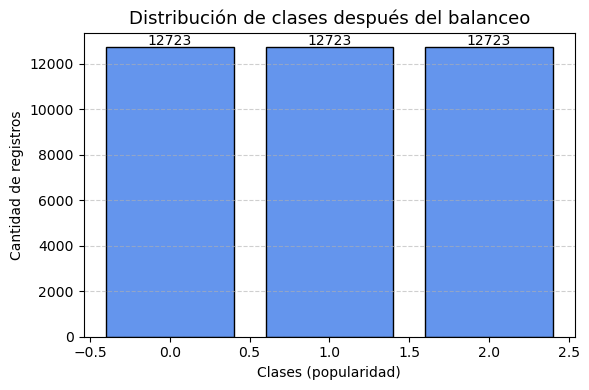

In [105]:
import matplotlib.pyplot as plt

# Conteo de clases balanceadas
counts_after = y_train_bal.value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(counts_after.index, counts_after.values, color="cornflowerblue", edgecolor="black")
plt.title("Distribución de clases después del balanceo", fontsize=13)
plt.xlabel("Clases (popularidad)")
plt.ylabel("Cantidad de registros")
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, val in enumerate(counts_after.values):
    plt.text(i, val + 100, str(val), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


### Reduccion Dimensionalidad

In [106]:
selector = SelectKBest(mutual_info_classif, k=8)

X_train_best = selector.fit_transform(X_train_bal, y_train_bal)
X_test_best = selector.transform(X_test)

selected_indices = selector.get_support()
selected_features = X_train.columns[selected_indices]
scores = selector.scores_[selected_indices]

print("\nCaracterísticas seleccionadas (Inf. mutua ordenadas):")

# Emparejar características con sus scores y ordenar
sorted_features = sorted(zip(selected_features, scores), key=lambda x: x[1], reverse=True)

# Imprimir ordenadas
for feature, score in sorted_features:
    print(f"{feature}: {score:.4f}")


Características seleccionadas (Inf. mutua ordenadas):
vote_count: 0.5345
vote_average: 0.4210
production_companies_te: 0.3221
production_countries_te: 0.2238
runtime: 0.2182
spoken_languages_te: 0.2175
days_since_release: 0.1817
genres_Thriller: 0.0472


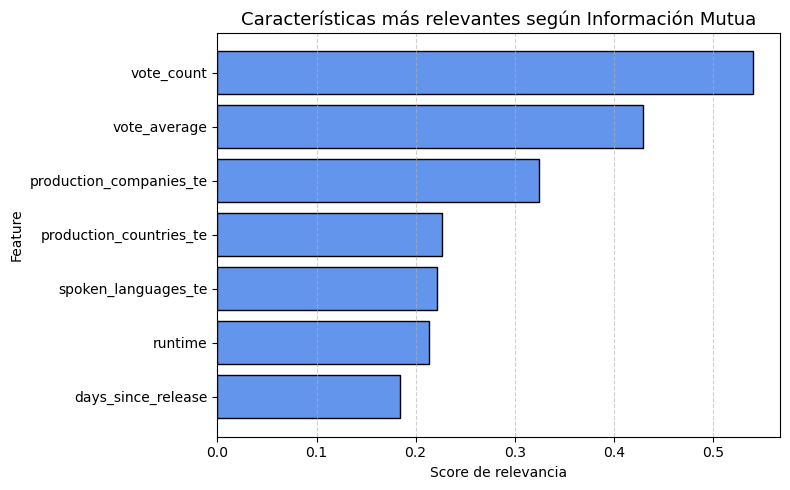

In [107]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear DataFrame con los resultados
data = {
    'feature': [
        'vote_count', 'vote_average', 'production_companies_te',
        'production_countries_te', 'spoken_languages_te',
        'runtime', 'days_since_release'
    ],
    'score': [0.5405, 0.4289, 0.3248, 0.2265, 0.2220, 0.2137, 0.1842]
}

df_scores = pd.DataFrame(data).sort_values(by='score', ascending=True)

# Gráfico de barras horizontal
plt.figure(figsize=(8,5))
plt.barh(df_scores['feature'], df_scores['score'], color="cornflowerblue", edgecolor="black")
plt.title("Características más relevantes según Información Mutua", fontsize=13)
plt.xlabel("Score de relevancia")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Evaluación de modelos de clasificación

### Función para mostrar métricas

In [108]:
def evaluar_modelo(
    y_train, y_pred_train,
    y_test, y_pred_test,
    etiquetas=None,
    nombre_modelo="Modelo",
):
    """
    Evalúa y visualiza un modelo de clasificación.
    Muestra reportes de clasificación y matrices de confusión en una figura 2x2.
    Devuelve un DataFrame con métricas promedio (macro) para train y test.
    """

    # Métricas básicas
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Reportes de clasificación (texto y diccionario)
    report_train_text = classification_report(y_train, y_pred_train, target_names=etiquetas)
    report_test_text = classification_report(y_test, y_pred_test, target_names=etiquetas)
    report_train_dict = classification_report(y_train, y_pred_train, target_names=etiquetas, output_dict=True)
    report_test_dict = classification_report(y_test, y_pred_test, target_names=etiquetas, output_dict=True)

    # Matrices de confusión
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # Figura general (2x2)
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(
        2, 2, figure=fig,
        height_ratios=[0.7, 1.3],   # proporciones: reportes más chicos, matrices más altas
        top=0.87, bottom=0.08,
        left=0.07, right=0.95,
        hspace=0.22, wspace=0.15
    )

    # Título principal
    fig.text(0.5, 0.965, f"Evaluación del Modelo - {nombre_modelo}",
             ha="center", va="top", fontsize=14, fontweight="bold")

    # Reporte de clasificación - TRAIN
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.axis("off")
    ax1.text(0, 1, f"=== TRAIN ===\n\n{report_train_text}",
             fontsize=8, family="monospace", va="top")
    ax1.set_title("Reporte de Clasificación (Train)", fontsize=10, pad=4)

    # Reporte de clasificación - TEST
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis("off")
    ax2.text(0, 1, f"=== TEST ===\n\n{report_test_text}",
             fontsize=8, family="monospace", va="top")
    ax2.set_title("Reporte de Clasificación (Test)", fontsize=10, pad=4)

    # Matriz de confusión - TRAIN
    ax3 = fig.add_subplot(gs[1, 0])
    disp_train = ConfusionMatrixDisplay(cm_train, display_labels=etiquetas)
    disp_train.plot(ax=ax3, cmap="Blues", values_format='d', colorbar=False)
    ax3.set_title("Matriz de Confusión - Train", fontsize=10)

    # Matriz de confusión - TEST
    ax4 = fig.add_subplot(gs[1, 1])
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=etiquetas)
    disp_test.plot(ax=ax4, cmap="Oranges", values_format='d', colorbar=False)
    ax4.set_title("Matriz de Confusión - Test", fontsize=10)

    plt.show()

    # Resumen con métricas promedio (macro)
    resumen = pd.DataFrame({
        "Modelo": [nombre_modelo],
        "Accuracy_Train": [acc_train],
        "Accuracy_Test": [acc_test],
        "Precision_Train": [report_train_dict["macro avg"]["precision"]],
        "Precision_Test": [report_test_dict["macro avg"]["precision"]],
        "Recall_Train": [report_train_dict["macro avg"]["recall"]],
        "Recall_Test": [report_test_dict["macro avg"]["recall"]],
        "F1_Train": [report_train_dict["macro avg"]["f1-score"]],
        "F1_Test": [report_test_dict["macro avg"]["f1-score"]],
    })

    return resumen

resumenes = []


### Logistic Regression

Modelo para usar de base con parámetros por defecto.

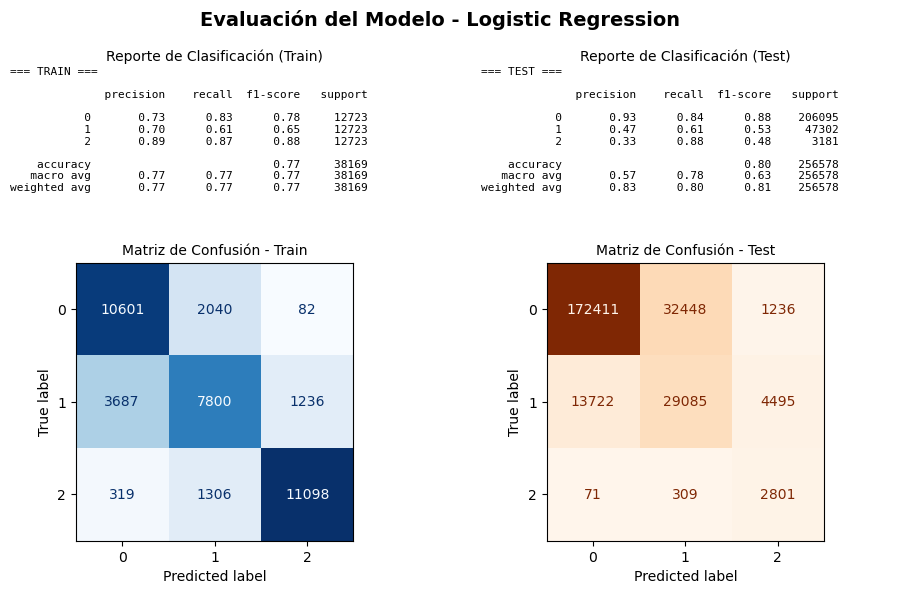

,Modelo,Accuracy_Train,Accuracy_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
0,Logistic Regression,0.772852,0.796237,0.773132,0.574843,0.772852,0.777327,0.770759,0.630072


In [109]:
from sklearn.linear_model import LogisticRegression

# Modelo

log_reg = LogisticRegression(
    random_state=42
)

# Entrenamiento

log_reg.fit(X_train_best, y_train_bal)

# Predicciones

y_pred_train = log_reg.predict(X_train_best)
y_pred_test = log_reg.predict(X_test_best)

# Evaluación

resumen = evaluar_modelo(
    y_train_bal, y_pred_train, y_test, y_pred_test,
    etiquetas=None,
    nombre_modelo="Logistic Regression"
)

resumenes.append(resumen)

resumen


### SVM (RBF)

Se utiliza el kernel RBF que permite fronteras no lineales.
Se ajustan C y gamma para equilibrar precisión y generalización.

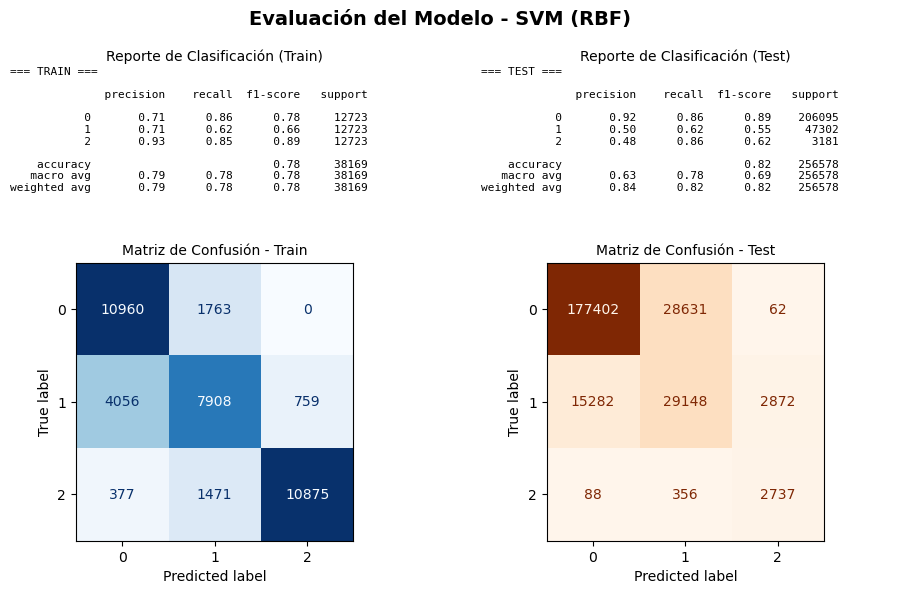

,Modelo,Accuracy_Train,Accuracy_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
0,SVM (RBF),0.779245,0.815686,0.785506,0.634761,0.779245,0.779137,0.778441,0.68694


In [110]:
from sklearn.svm import SVC

svm_rbf = SVC(
    kernel='rbf',          
    C=5.0,                 
    gamma=0.5,         
    probability=False,     
    random_state=42
)

# Entrenamiento

svm_rbf.fit(X_train_best, y_train_bal)

# Predicciones

y_pred_train = svm_rbf.predict(X_train_best)
y_pred_test = svm_rbf.predict(X_test_best)

# Evaluación 

resumen = evaluar_modelo(
    y_train_bal, y_pred_train,
    y_test, y_pred_test,
    etiquetas=None,
    nombre_modelo="SVM (RBF)"
)

resumenes.append(resumen)

resumen


### MLP

Época 1/100 - Loss: 0.6176
Época 10/100 - Loss: 0.4882
Época 20/100 - Loss: 0.4728
Época 30/100 - Loss: 0.4636
Época 40/100 - Loss: 0.4566
Época 50/100 - Loss: 0.4530
Época 60/100 - Loss: 0.4496
Época 70/100 - Loss: 0.4468
Época 80/100 - Loss: 0.4455
Época 90/100 - Loss: 0.4453
Época 100/100 - Loss: 0.4410


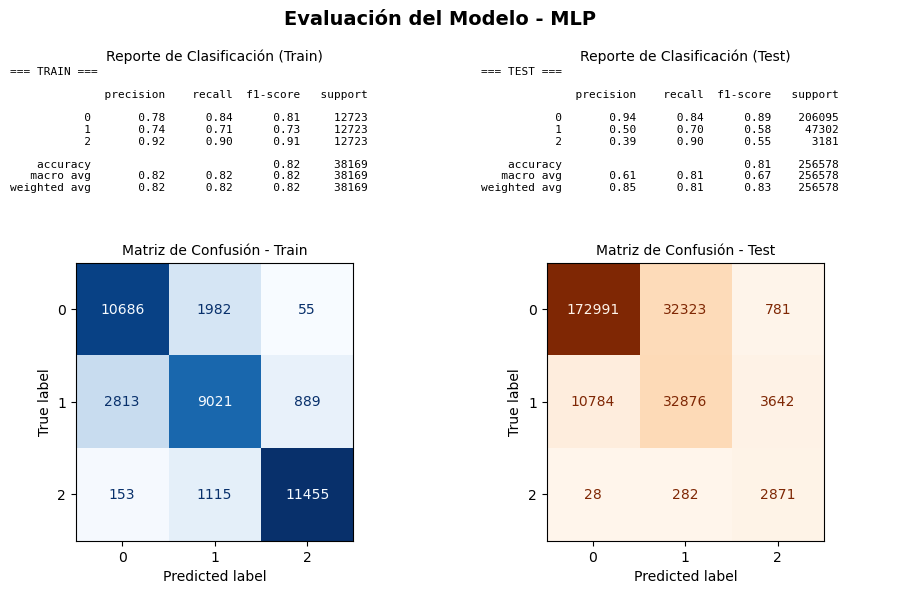

,Modelo,Accuracy_Train,Accuracy_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
0,MLP,0.816422,0.813546,0.817012,0.612286,0.816422,0.812315,0.816187,0.672841


In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Crear tensores

X_train_t = torch.tensor(X_train_best, dtype=torch.float32)
y_train_t = torch.tensor(y_train_bal.values, dtype=torch.long)
X_test_t = torch.tensor(X_test_best, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.long)

# DataLoaders para batches

batch_size = 512
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

input_dim = X_train_best.shape[1]
output_dim = len(np.unique(y_train_bal))

# Definición de la red neuronal

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=3, dropout_rate=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Creacion del modelo

model = MLP(
    input_dim=input_dim,
    hidden_dim=128,
    output_dim=output_dim,
    dropout_rate=0.2
)

# Función de pérdida y optimizador

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Entrenamiento

epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad(set_to_none=True)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        avg_loss = running_loss / len(train_loader)
        print(f"Época {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# Modo evaluación

model.eval()

# DataLoader sin shuffle para evaluación completa

train_eval_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=8192, shuffle=False)

# Predicciones en train

y_true_train, y_pred_train = [], []
with torch.no_grad():
    for Xb, yb in train_eval_loader:
        outputs = model(Xb)
        y_true_train.extend(yb.numpy())
        y_pred_train.extend(torch.argmax(outputs, dim=1).numpy())

# Predicciones en test

y_true_test, y_pred_test = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        outputs = model(Xb)
        y_true_test.extend(yb.numpy())
        y_pred_test.extend(torch.argmax(outputs, dim=1).numpy())

# Evaluación

resumen = evaluar_modelo(
    y_true_train, y_pred_train,
    y_true_test, y_pred_test,
    etiquetas=None,
    nombre_modelo="MLP"
)

resumenes.append(resumen)

resumen


### XGBoost

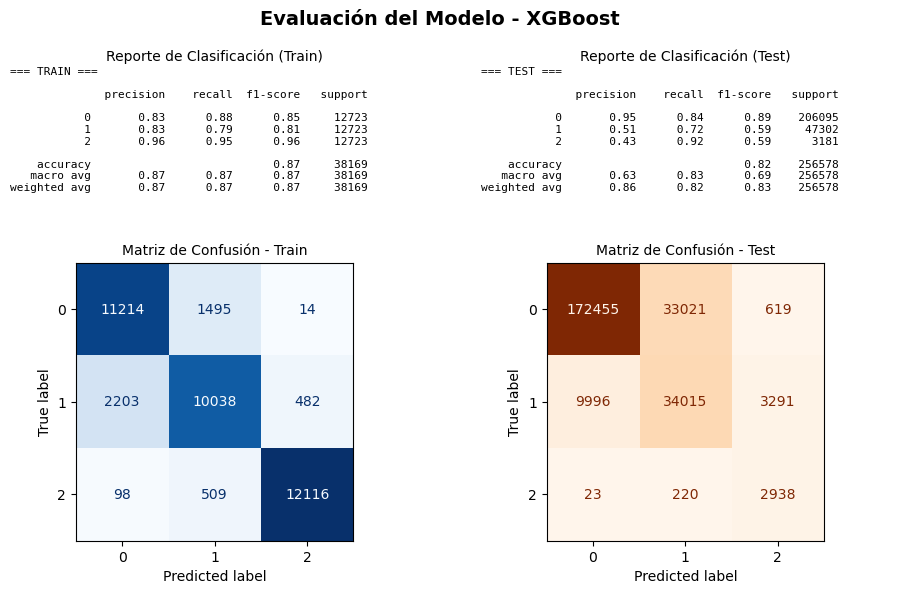

,Modelo,Accuracy_Train,Accuracy_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
0,XGBoost,0.874217,0.816157,0.874667,0.626626,0.874217,0.826495,0.873971,0.68913


In [112]:
from xgboost import XGBClassifier

# Modelo 

xgb = XGBClassifier(
    objective='multi:softprob',   # Clasificación multiclase (probabilidades)
    num_class=3,                  # Número de clases
    eval_metric='mlogloss',       # Métrica de evaluación
    random_state=42   
)

# Entrenamiento

xgb.fit(X_train_best, y_train_bal)

# Predicciones

y_pred_train = xgb.predict(X_train_best)
y_pred_test = xgb.predict(X_test_best)

# Evaluación

resumen = evaluar_modelo(
    y_train_bal, y_pred_train,
    y_test, y_pred_test,
    etiquetas=None,
    nombre_modelo="XGBoost",
)

resumenes.append(resumen)

resumen


### One-vs-Rest (OVR, Decision Trees)

Entrena un modelo binario independiente para cada clase.Cada modelo aprende a distinguir entre “pertenece a esta clase” y “no pertenece a esta clase”. En la fase de predicción, todos los clasificadores generan una probabilidad o puntaje de pertenencia, y la clase final se asigna según el valor más alto.

Se utilizaron árboles de decisión como modelos base dentro del esquema OVR porque permiten capturar relaciones no lineales y efectos de interacción entre variables

Se empleó un conjunto de validación separado para ajustar los umbrales de decisión por clase, buscando maximizar el equilibrio entre precisión y sensibilidad (F1-score) en datos desbalanceados.

Clase 0: mejor umbral (val) = 0.467, F1_val = 0.810
Clase 1: mejor umbral (val) = 0.431, F1_val = 0.733
Clase 2: mejor umbral (val) = 0.439, F1_val = 0.908


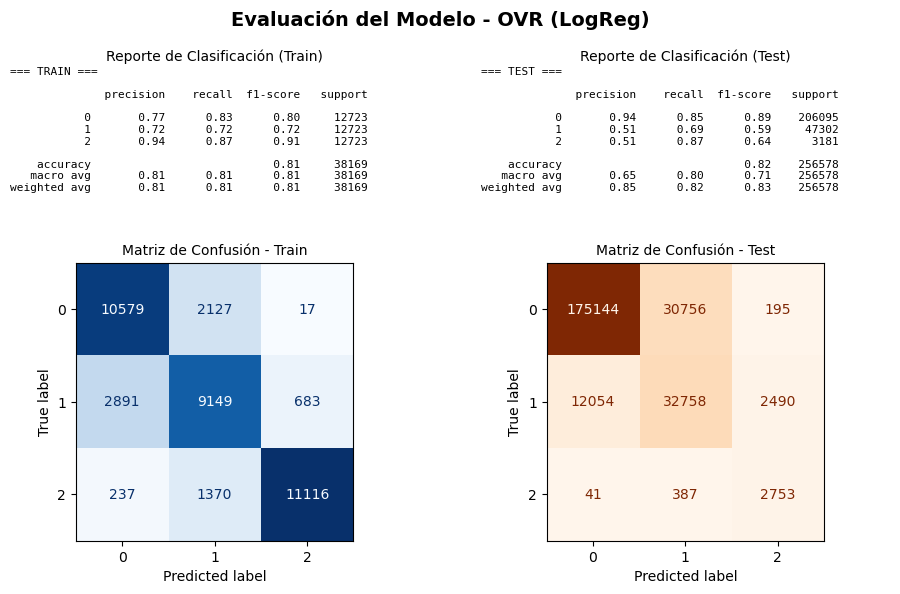

,Modelo,Accuracy_Train,Accuracy_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
0,OVR (LogReg),0.80809,0.821017,0.812008,0.651431,0.80809,0.802601,0.809263,0.70618


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# División del conjunto de validación (para ajustar umbrales)

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_best, y_train_bal,
    test_size=0.2,
    stratify=y_train_bal,
    random_state=42
)

# Modelo base y OVR

#base_model = LogisticRegression(random_state=42)

base_model = DecisionTreeClassifier(
    max_depth=6,          
    min_samples_leaf=20,  
    random_state=42
)

ovr = OneVsRestClassifier(base_model)

# Entrenamiento

ovr.fit(X_train_sub, y_train_sub)

# Cálculo de umbrales óptimos en validación

probs_val = ovr.predict_proba(X_val)
n_clases = probs_val.shape[1]
thresholds = []

for i in range(n_clases):
    y_true_bin = (y_val == i).astype(int)
    precision, recall, thr = precision_recall_curve(y_true_bin, probs_val[:, i])
    f1 = np.nan_to_num(2 * precision * recall / (precision + recall))
    best_idx = np.argmax(f1)
    best_thresh = thr[best_idx] if best_idx < len(thr) else 0.5
    thresholds.append(best_thresh)
    print(f"Clase {i}: mejor umbral (val) = {best_thresh:.3f}, F1_val = {f1[best_idx]:.3f}")

# Predicción en test usando los umbrales óptimos

probs_test = ovr.predict_proba(X_test_best)
y_pred_thresh = np.zeros_like(y_test)

for j in range(len(y_test)):
    sample_probs = probs_test[j, :]
    binary_scores = (sample_probs > thresholds).astype(int)
    y_pred_thresh[j] = np.argmax(binary_scores) if np.sum(binary_scores) > 0 else np.argmax(sample_probs)

# Evaluación 

resumen = evaluar_modelo(
    y_train_bal, ovr.predict(X_train_best),
    y_test, y_pred_thresh,
    etiquetas=None,
    nombre_modelo="OVR (Decision Trees)"
)

resumenes.append(resumen)

resumen


## Comparación Modelos Clasificación

In [114]:
df_resultados = pd.concat(resumenes, ignore_index=True)
display(df_resultados.sort_values("Accuracy_Test", ascending=False))

,Modelo,Accuracy_Train,Accuracy_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
4,OVR (LogReg),0.808090,0.821017,0.812008,0.651431,0.808090,0.802601,0.809263,0.706180
3,XGBoost,0.874217,0.816157,0.874667,0.626626,0.874217,0.826495,0.873971,0.689130
1,SVM (RBF),0.779245,0.815686,0.785506,0.634761,0.779245,0.779137,0.778441,0.686940
2,MLP,0.816422,0.813546,0.817012,0.612286,0.816422,0.812315,0.816187,0.672841
0,Logistic Regression,0.772852,0.796237,0.773132,0.574843,0.772852,0.777327,0.770759,0.630072


Los valores de Accuracy observados entre los conjuntos de train y test son muy similares en todos los modelos (diferencias menores al 3%), lo que indica una buena capacidad de generalización. Esto sugiere que los modelos no están sobreajustando.

La caída en la precisión respecto al entrenamiento se explica principalmente por el alto desbalance del dataset, donde las clases más frecuentes (películas poco populares) dominan el aprendizaje. Los modelos tienden a predecir más casos positivos para las clases minoritarias, lo que aumenta los falsos positivos y reduce la precisión. Sin embargo, el recall se mantiene alto porque los modelos siguen identificando correctamente la mayoría de las instancias verdaderamente positivas.

Entre los modelos evaluados, el esquema One-vs-Rest con umbrales ajustados muestra el mejor Acurracy y F1 con mas equilibrio entre precisión y recall. 

### Evaluación en test balanceado

A continuación se muestran los resultados de evaluacion del modelo XGBoost sobre un conjunto de test balanceado, que si bien no refleja la realidad del dataset, permite visualizar como el desbalance afecta lasmñetricas de los modelos

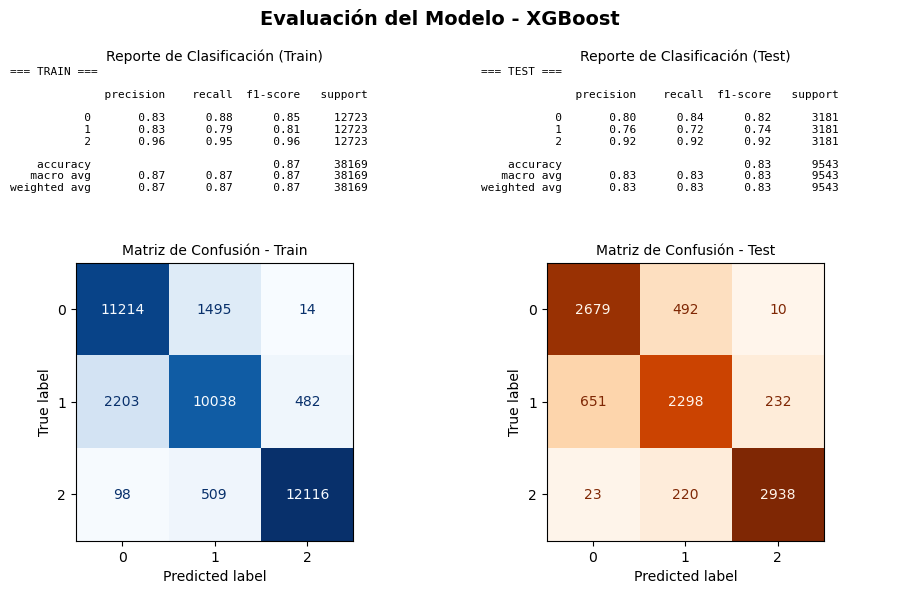

,Modelo,Accuracy_Train,Accuracy_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
0,XGBoost,0.874217,0.829404,0.874667,0.82878,0.874217,0.829404,0.873971,0.828713


In [115]:
# Balanceo de test

X_test_bal, y_test_bal = bal.fit_resample(X_test_best, y_test)

# Predicciones

y_pred_bal = xgb.predict(X_test_bal)

# Evaluación

resumen = evaluar_modelo(
    y_train_bal, y_pred_train,
    y_test_bal, y_pred_bal,
    etiquetas=None,
    nombre_modelo="XGBoost",
)

resumen

Al evaluar el modelo sobre un conjunto de test balanceado, se observa una mejora clara en las métricas de precision y F1-score. Esto indica que el modelo logra identificar correctamente las clases minoritarias cuando están representadas en proporciones similares.